# Training Dataset

In [15]:
import numpy as np

import matplotlib.cm as cm  # Import cm for colormap
import matplotlib.pyplot as plt

seed = 42

import torch
torch.manual_seed(seed)

import numpy as np
np.random.seed(seed)

import random
random.seed(seed)

In [16]:
###### Generate Data ######
def polynom(X):
  return 0 + X + -5 * X**2 + 1.5*X ** 3

def generate(N=1000):
  X = np.random.uniform(-1, 1.5, N)
  Y = 0 + X + -5 * X**2 + 1.5*X ** 3
  Y += np.random.randn(Y.shape[0]) / 5
  return torch.tensor(X).float()[:, None], torch.tensor(Y)[:, None].float()

X_data, Y_data = generate(100)
Y_data += 3.5
Y_data /= 15
Y_data -= 0.2

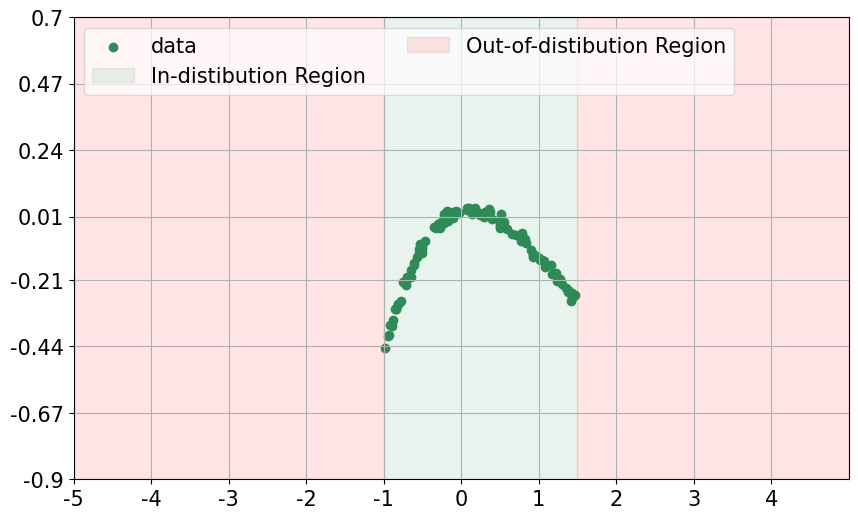

In [17]:
###### Data Visualization ######
fig, (ax) = plt.subplots(1, 1, figsize=(10, 6))
X_min, X_max = -5, 5

ax.grid()
ax.scatter(X_data, Y_data, color="seagreen", label="data")

Y_min, Y_max = -0.9, 0.7
ax.fill_between([-1, 1.5], Y_min, Y_max, color='seagreen', alpha=0.1, label="In-distibution Region")
ax.fill_between([1.5, X_max], Y_min, Y_max, color='red', alpha=0.1, label="Out-of-distibution Region")
ax.fill_between([X_min, -1], Y_min, Y_max, color='red', alpha=0.1)

ax.legend(fontsize=15, ncol=2, loc='upper left', framealpha=0.7)
ax.grid()
ax.set_xlim(X_min, X_max)
ax.set_ylim(Y_min, Y_max)
ax.set_yticks(np.linspace(Y_min, Y_max, 8).round(2))
ax.set_yticklabels(np.linspace(Y_min, Y_max, 8).round(2), fontsize=15)
ax.set_xticks(range(-5, 5, 1))
ax.set_xticklabels(range(-5, 5, 1), fontsize=15)
ax.grid()

In [18]:
###### Model Architechture ######

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

A = -1 # initial value of the second argument
class Net(torch.nn.Module):

  def __init__(self, hidden_layer=100):
    super().__init__()

    self.hidden_layer = hidden_layer
    self.fc1 = torch.nn.Linear(2, hidden_layer)
    self.fc2 = torch.nn.Linear(hidden_layer, 1)
    self.activation = torch.nn.LeakyReLU()

  def forward(self, x, y=None):

    if y is None:
      x = torch.concat([x, -A * torch.ones([x.shape[0], 1])], dim=1)

    else:
      x = torch.concat([x, y], dim=1)

    x = self.activation(self.fc1(x))
    x = self.fc2(x)

    return x

###### Optimization Step ######
I = 3 # number of iterations
def step(epoch, model, optimizer, criterion, X_data, Y_data, l_gradient_penalty):

    model.train()
    optimizer.zero_grad()

    Y_0 = network(X_data, -A*torch.ones_like(Y_data))
    loss = criterion(Y_0, Y_data)

    Y_t = Y_0
    for _ in range(I):
      Y_t = network(X_data, Y_t)
      loss += criterion(Y_t, Y_data)

    loss.backward()
    optimizer.step()

    return loss.item()

epochs = 150

network = Net(hidden_layer=128)

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.05)

network.train()

###### Training ######
for epoch in range(epochs):
    network.train()
    step(epoch, network, optimizer, criterion, X_data, Y_data, 3e-4)

<ipython-input-19-64bf4a5e6da4>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('winter', len(preds))  # 'winter' colormap goes from blue to green


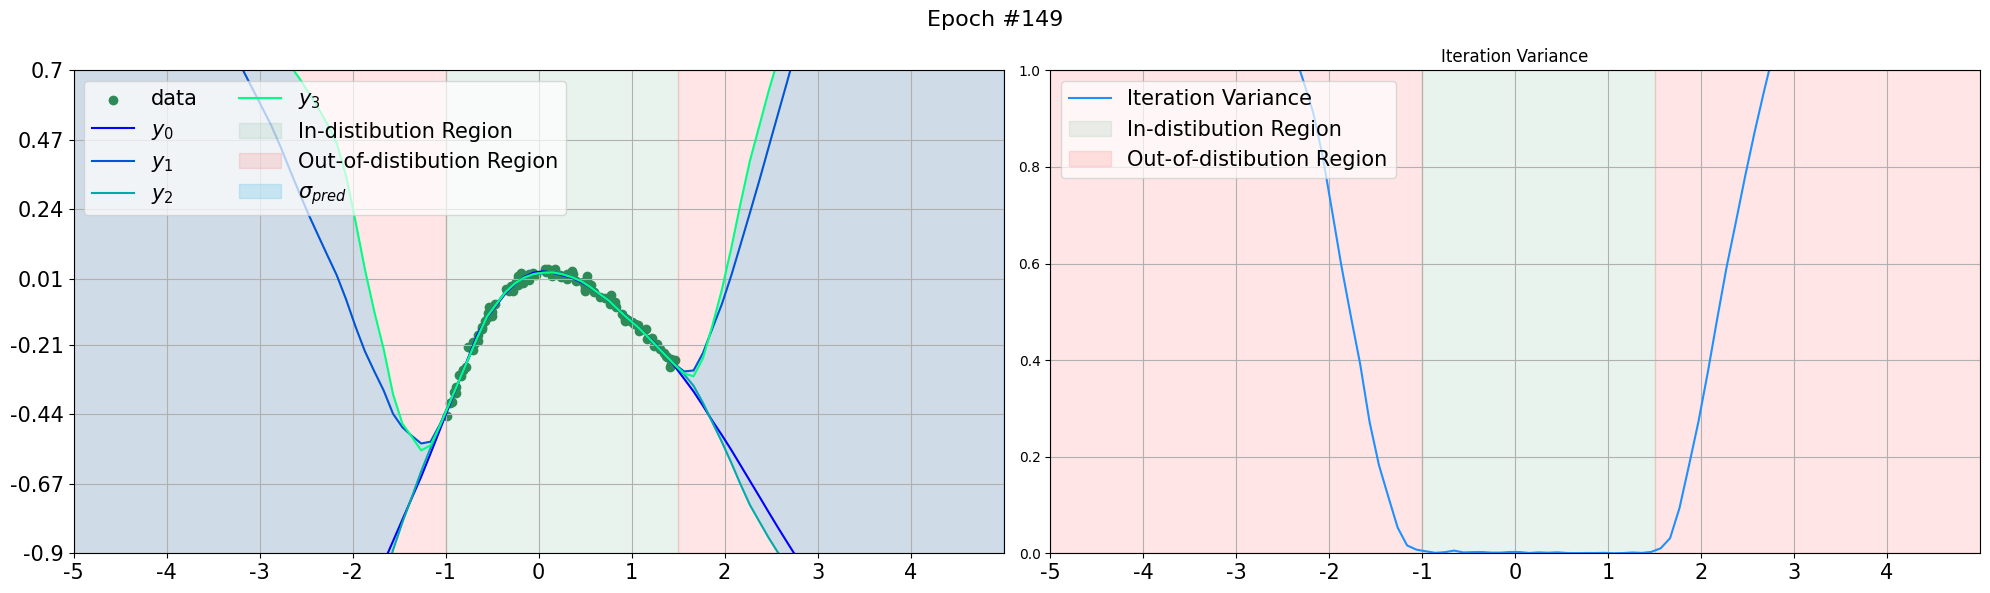

In [19]:
###### Visualize Final Result ######
network.eval()

X_min, X_max = -5, 5
Xt = torch.linspace(X_min, X_max, 100)[:, None]

Y_1 = network(Xt)
Y_t = Y_1.detach()

preds = [Y_t]
for _ in range(I):
  Y_t = network(Xt, Y_t)
  Y_t = Y_t.detach()
  Y_final = Y_t
  preds.append(Y_final)

preds = torch.stack(preds)

error = torch.std(preds, dim=0).detach()

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax = ax1
ax.grid()

cmap = cm.get_cmap('winter', len(preds))  # 'winter' colormap goes from blue to green

ax.scatter(X_data, Y_data, color="seagreen", label="data")
for i, p in enumerate(preds):
  color = cmap(i)
  ax.plot(Xt, p, c=color, label=f"$y_{i}$")

Y_min, Y_max = -0.9, 0.7
ax.fill_between([-1, 1.5], Y_min, Y_max, color='seagreen', alpha=0.1, label="In-distibution Region")
ax.fill_between([1.5, X_max], Y_min, Y_max, color='red', alpha=0.1, label="Out-of-distibution Region")
ax.fill_between([X_min, -1], Y_min, Y_max, color='red', alpha=0.1)
ax.fill_between(Xt[:, 0], preds.min(dim=0)[0][:, 0], preds.max(dim=0)[0][:, 0], alpha=0.4, color="skyblue", label="$\sigma_{pred}$")

ax.legend(fontsize=15, ncol=2, loc='upper left', framealpha=0.7)
ax.grid()
ax.set_xlim(X_min, X_max)
ax.set_ylim(Y_min, Y_max)
ax.set_yticks(np.linspace(Y_min, Y_max, 8).round(2))
ax.set_yticklabels(np.linspace(Y_min, Y_max, 8).round(2), fontsize=15)
ax.set_xticks(range(-5, 5, 1))
ax.set_xticklabels(range(-5, 5, 1), fontsize=15)
ax.grid()

ax = ax2
ax.set_title("Iteration Variance")
plt.plot(Xt[:, 0], error, c="dodgerblue", label="Iteration Variance")
ax.fill_between([-1, 1.5], 0, 1, color='seagreen', alpha=0.1, label="In-distibution Region")
ax.fill_between([1.5, X_max], 0, 1, color='red', alpha=0.1, label="Out-of-distibution Region")
ax.fill_between([X_min, -1], 0, 1, color='red', alpha=0.1)
ax.legend(fontsize=15, loc='upper left', framealpha=0.7)
ax.grid(True)
ax.set_xlim(-5, 5)
ax.set_ylim(0, 1)
ax.set_xticks(range(-5, 5, 1))
ax.set_xticklabels(range(-5, 5, 1), fontsize=15)

fig.suptitle(f"Epoch #{epoch}", fontsize=16)

plt.tight_layout()
plt.show()